# Project 1

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder,Normalizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from timeit import default_timer as timer

Below is two function that clean the training file of adult dataset that delete row with question mark and return a pandas format of the cleaned version. 

In [18]:
def adult_clean_train(file,length): #clean the data and return it as a numpy format length is the first num of rows we want to take
    df = pd.read_csv(file,header=None,skipinitialspace=True)
    df.columns = ["age", "workclass", "fnlwgt", "education", "education_num",
                                   "marital_status", "occupation", "relationship", "race", "sex",
                                   "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"]
    for attributes in df.columns:
        df = df[df[attributes] != '?']

    df = df.sample(frac=length,random_state=1)
    return df

def adult_clean_test(file):
    df = pd.read_csv(file, header=None, skiprows=1,skipinitialspace=True)
    df.columns = ["age", "workclass", "fnlwgt", "education", "education_num",
                  "marital_status", "occupation", "relationship", "race", "sex",
                  "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"]
    for attributes in df.columns:
        df = df[df[attributes] != '?']
    df["income"] = df["income"].str.replace(".", "",regex=False)
    return df

Below function is to preprocess the train data by encoding the discrete value and normalizing the continous one and split the train feature, train label, test feature, test label.

In [19]:
def adult_preprocess(cleaned_data, test_data,normalize_type):
    # fnlwgt = (fnlwgt-fnlwgt.mean())/(fnlwgt.std())

    frames = [cleaned_data, test_data]
    line_num = cleaned_data.shape[0]
    cleaned_data = pd.concat(frames, axis=0)
    normalizer = Normalizer(norm=normalize_type)

    enc1 = OneHotEncoder(handle_unknown='ignore', sparse=False)

    age = cleaned_data[['age']].to_numpy().T  # continous needs squeeze
    age = normalizer.fit_transform(age)  # normalization
    age = np.squeeze(age)

    workclass = enc1.fit_transform(cleaned_data[['workclass']].to_numpy()).T  # categorical

    fnlwgt = cleaned_data[['fnlwgt']].to_numpy().T  # continuous
    fnlwgt = normalizer.fit_transform(fnlwgt)  # normalization
    fnlwgt = np.squeeze(fnlwgt)

    education = enc1.fit_transform(cleaned_data[['education']].to_numpy()).T  # categorical

    education_num = cleaned_data[['education_num']].to_numpy().T  # continuous
    education_num = normalizer.fit_transform(education_num)
    education_num = np.squeeze(education_num)

    marital_status = enc1.fit_transform(cleaned_data[['marital_status']].to_numpy()).T  # categorical

    occupation = enc1.fit_transform(cleaned_data[['occupation']].to_numpy()).T  # categorical

    relationship = enc1.fit_transform(cleaned_data[['relationship']].to_numpy()).T  # categorical

    race = enc1.fit_transform(cleaned_data[['race']].to_numpy()).T  # categorical

    sex = enc1.fit_transform(cleaned_data[['sex']].to_numpy()).T  # categorical

    capital_gain = cleaned_data[['capital_gain']].to_numpy().T  # continuous
    capital_gain = normalizer.fit_transform(capital_gain)  # normalization
    capital_gain = np.squeeze(capital_gain)

    capital_loss = cleaned_data[['capital_loss']].to_numpy().T  # continuous
    capital_loss = normalizer.fit_transform(capital_loss)  # normalization
    capital_loss = np.squeeze(capital_loss)

    hours_per_week = cleaned_data[['hours_per_week']].to_numpy().T  # continuous
    hours_per_week = normalizer.fit_transform(hours_per_week)  # normalization
    hours_per_week = np.squeeze(hours_per_week)

    native_country = enc1.fit_transform(cleaned_data[['native_country']].to_numpy()).T  # categorical
    enc_feature = np.vstack([age, workclass, fnlwgt, education, education_num, marital_status, occupation,
                             relationship, race, sex, capital_gain, capital_loss, hours_per_week, native_country]).T
    # print(enc_feature.shape)
    enc_label = enc1.fit_transform(cleaned_data[['income']].to_numpy())
    enc1_feature = enc_feature[:line_num, :]
    # print(enc1_feature.shape)
    # print(line_num)
    test_feature = enc_feature[line_num:, :]
    # print(test_feature.shape)
    enc1_label = enc_label[:line_num, :]
    test_label = enc_label[line_num:, :]
    pre_processed_tuple = (enc1_feature, enc1_label, test_feature, test_label)
    return pre_processed_tuple

Same processes as clean and preprocess for adult dataset but this is for occupancy dataset. 

In [20]:
def occupancy_clean(file,length):
    df = pd.read_csv(file, header=None,skiprows=1, skipinitialspace=True)
    df.columns = ["num","date","Temperature","Humidity","Light","CO2","HumidityRatio","Occupancy"]
    df = df.drop(["num","date"], axis = 1)

    df = df.sample(frac=length,random_state=1)
    return df

def occupancy_preprocess(cleaned_data,normalize_type):
    normalizer = Normalizer(norm=normalize_type)
    enc1 = OneHotEncoder(handle_unknown='ignore', sparse=False)

    Temperature = cleaned_data[['Temperature']].to_numpy().T
    Temperature = normalizer.fit_transform(Temperature)
    Temperature = np.squeeze(Temperature)

    Humidity = cleaned_data[['Humidity']].to_numpy().T
    Humidity = normalizer.fit_transform(Humidity)
    Humidity = np.squeeze(Humidity)

    Light = cleaned_data[['Light']].to_numpy().T
    Light = normalizer.fit_transform(Light)
    Light = np.squeeze(Light)

    CO2 = cleaned_data[['CO2']].to_numpy().T
    CO2 = normalizer.fit_transform(CO2)
    CO2 = np.squeeze(CO2)

    HumidityRatio = cleaned_data[['HumidityRatio']].to_numpy().T
    HumidityRatio = normalizer.fit_transform(HumidityRatio)
    HumidityRatio = np.squeeze(HumidityRatio)

    enc_feature = np.vstack([Temperature, Humidity, Light, CO2, HumidityRatio]).T
    enc_label = enc1.fit_transform(cleaned_data[['Occupancy']].to_numpy())
    pre_processed_tuple = (enc_feature, enc_label)
    return pre_processed_tuple

This is the 5 fold cross validation we implemented for the knn it contain the tuple of train data. an integer representing the neighbors we want to test from 1 to range_neighbors and the weight = distance/uniform. And return the best accuracy and its hyperparameter and print a graph.

In [21]:
def knn_k_fold(data_tuple,range_neighbors,weight,label):
    
    enc_feature = data_tuple[0]
    #print(enc_feature.shape)
    enc_label = data_tuple[1]
    #print(enc_label.shape)
    
    line_num = enc_feature.shape[0]
    set_num = line_num//5 # numbers of data with in a set
    best_acc = 0 #records the best accuracy
    best_num_neighbours = 0 #records how many neighbours obtain the best accuracy
    
    knn_accuracy = [] # for graph
    
    for n_neighbors in np.arange(1,range_neighbors+1):
        acc_set = []
        for i in np.arange(0,5): # 5 times of cross validation
            knn_model = KNeighborsClassifier(n_neighbors=n_neighbors,weights=weight)
            for j in np.arange(0,5): # fit times
                if j == i:
                    continue
                elif (j == 4):
                    feature_set = enc_feature[set_num * 4:, :]
                    label_set = enc_label[set_num * 4:, :]
                    knn_model.fit(feature_set,label_set)
                else:
                    feature_set = enc_feature[set_num * j:set_num * (j+1), :]
                    label_set = enc_label[set_num * j:set_num * (j+1), :]
                    knn_model.fit(feature_set, label_set)
            if i == 4:
                test_set_feature = enc_feature[set_num * 4: , :]
                test_set_label = enc_label[set_num * 4: , :]
                pred = knn_model.predict(test_set_feature)
                acc_set.append(accuracy_score(test_set_label,pred))
            else:
                test_set_feature = enc_feature[set_num * i : set_num * (i+1), :]
                test_set_label = enc_label[set_num * i: set_num * (i + 1), :]
                pred = knn_model.predict(test_set_feature)
                acc_set.append(accuracy_score(test_set_label,pred)) # only a list so far need to make to a numpy
        np_acc_set = np.array(acc_set)
        acc_k_neighbour = np.mean(np_acc_set) #accuracy of this k neighbors
        #print("Accuracy for ", n_neighbors , "Neighbor is", acc_k_neighbour)
        knn_accuracy.append(acc_k_neighbour) # for graph
        
        if(best_acc < acc_k_neighbour):
            best_acc = acc_k_neighbour
            best_num_neighbours = n_neighbors
            
    x_axis = np.array(range(1,range_neighbors+1))
    #plt.subplot(2,2,1)
    plt.title("KNN accuracy \n and number of neighbors")
    plt.plot(x_axis, knn_accuracy,label=label)
    plt.xlabel('number of neighbors')
    plt.ylabel('accuracy')
    plt.legend()
    #plt.savefig('knn.jpg')
    return [best_num_neighbours,knn_accuracy[best_num_neighbours-1]]

Down below is the kfold we implemeted for decision tree it also contain the train tuple. However, for this function we took away the functionailty of choosing its own range when calling the function since we are calculating which combination of two hyperparameter gives us the best accuraccy. So we took away the functionaility to avoid people trying to overtest it and cause the code to slow down by a lot. We make it 20/12 and through testing it is a good range that not only give us good reusult but also good perforamce time. It return a list of a list with the best hyperparameter combination and also an floating point indicating its accuracy. 

In [22]:
def decision_tree_k_fold(data_tuple, label):
    enc_feature = data_tuple[0]
    enc_label = data_tuple[1]

    line_num = enc_feature.shape[0]
    set_num = line_num // 5  # numbers of data with in a set
    best_acc = 0  # records the best accuracy
    best_depth = 0  # records how many neighbours obtain the best accuracy
    best_depth_size = []
    dt_accuracy = []  # for graph
    for leaf_size in np.arange(1, 21):
        for tree_depth in np.arange(1, 13):
            acc_set = []
            for i in np.arange(0, 5):  # 5 times of cross validation
                tree_model = DecisionTreeClassifier(max_depth=tree_depth, min_samples_leaf=leaf_size,random_state=0)
                for j in np.arange(0, 5):  # fit times
                    if j == i:
                        continue
                    elif (j == 4):
                        feature_set = enc_feature[set_num * 4:, :]
                        label_set = enc_label[set_num * 4:, :]
                        tree_model.fit(feature_set, label_set)
                    else:
                        feature_set = enc_feature[set_num * j:set_num * (j + 1), :]
                        label_set = enc_label[set_num * j:set_num * (j + 1), :]
                        tree_model.fit(feature_set, label_set)
                if i == 4:
                    test_set_feature = enc_feature[set_num * 4:, :]
                    test_set_label = enc_label[set_num * 4:, :]
                    pred = tree_model.predict(test_set_feature)
                    acc_set.append(accuracy_score(test_set_label, pred))
                else:
                    test_set_feature = enc_feature[set_num * i: set_num * (i + 1), :]
                    test_set_label = enc_label[set_num * i: set_num * (i + 1), :]
                    pred = tree_model.predict(test_set_feature)
                    acc_set.append(accuracy_score(test_set_label, pred))  # only a list so far need to make to a numpy
            np_acc_set = np.array(acc_set)
            acc_tree_depth = np.mean(np_acc_set)  # acc for this set of depth and leaf size
            #print("Accuracy for ", tree_depth , "Max-depth", leaf_size, "Leaf-Size", acc_tree_depth)
            dt_accuracy.append(acc_tree_depth)  # for graph
            if acc_tree_depth >= best_acc:
                best_acc = acc_tree_depth
                best_depth_size = [tree_depth,leaf_size]
    
    size_1_depth = dt_accuracy[:12]
    
    depth_12_size = []
    for i in range(20):
        depth_12_size.append(dt_accuracy[11+i*12])
    
    plt.figure(1); plt.title("decision tree accuracy \n and tree depths(min_samples_leaf=1)")
    x_axis1 = np.array(range(1, 13))
    plt.xticks(x_axis1)
    plt.xlabel('maximum tree depth')
    plt.ylabel('accuracy')
    plt.plot(x_axis1, size_1_depth, label=label)
    plt.legend()
    
    plt.figure(2); plt.title("decision tree accuracy \n and min_samples_leaf(max_depth=12)")
    x_axis2=np.array(range(1,21))
    plt.xticks(x_axis2)
    plt.xlabel('minimum samples required to be a leaf node')
    plt.ylabel('accuracy')
    plt.plot(x_axis2, depth_12_size, label=label)
    plt.legend()
    
    return [best_depth_size,best_acc]

Below is the function that determine the training accuracy that takes in parameters like the above kfold and return a tuple of best k with its best accuracy 

In [23]:
def knn_train(data_tuple, range_neighbors, weight, label): #knn learn and predict on same set
    enc_feature = data_tuple[0]
    enc_label = data_tuple[1]
    best_acc = 0
    best_num_neighbours = 0
    knn_train_acc=[] #for graph
    for n_neighbors in np.arange(1, range_neighbors + 1):
        knn_model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weight)
        knn_model.fit(enc_feature, enc_label)
        pred = knn_model.predict(enc_feature)
        acc = accuracy_score(enc_label,pred)
        knn_train_acc.append(acc) #for graph
        if (acc >= best_acc):
            best_acc = acc
            best_num_neighbours = n_neighbors;

    x_axis = np.array(range(1,range_neighbors+1))
    plt.title("KNN training accuracy \n and number of neighbors")
    plt.plot(x_axis, knn_train_acc,label=label)
    plt.xlabel('number of neighbors')
    plt.ylabel('accuracy')
    plt.legend()

    return (best_num_neighbours, best_acc)

Below is the function were after all the validation and training we can use this to test our hyperparamter on unseen data and it return the accuracy score of the test. 

In [24]:
def knn_test(k, train_test_tuple,weight):
    train_feature = train_test_tuple[0]
    #print(train_feature.shape)
    train_label = train_test_tuple[1]
    #print(train_label.shape)
    test_feature = train_test_tuple[2]
    #print(test_feature.shape)
    test_label = train_test_tuple[3]
    #print(test_label.shape)
    
    model = KNeighborsClassifier(n_neighbors=k,weights=weight)
    model.fit(train_feature,train_label)
    result = model.predict(test_feature)
    return accuracy_score(test_label,result)

Similar to k_fold for decision tree this also takes in data_tuple (all label are only use for graphing), And return its  best hyperparamter alongside with its training accuracy. 

In [25]:
def decision_tree_train(data_tuple,label): #decision tree learn and predict on same set
    enc_feature = data_tuple[0]
    enc_label = data_tuple[1]
    best_acc = 0
    best_depth_size = []
    dt_train_acc=[] #for graph
    for leaf_size in np.arange(1, 21):
        for tree_depth in np.arange(1, 13):
            tree_model = DecisionTreeClassifier(max_depth=tree_depth, min_samples_leaf=leaf_size,random_state=0)
            tree_model.fit(enc_feature, enc_label)
            pred = tree_model.predict(enc_feature)
            acc = accuracy_score(enc_label,pred)
            dt_train_acc.append(acc) #for graph
            if (acc >= best_acc):
                best_acc = acc
                best_depth_size = [tree_depth, leaf_size]

    size_1_depth = dt_train_acc[:12]
    
    depth_12_size = []
    for i in range(20):
        depth_12_size.append(dt_train_acc[11+i*12])
    
    plt.figure(1); plt.title("decision tree training accuracy \n and tree depths(min_samples_leaf=1)")
    x_axis1 = np.array(range(1, 13))
    plt.xticks(x_axis1)
    plt.xlabel('maximum tree depth')
    plt.ylabel('accuracy')
    plt.plot(x_axis1, size_1_depth, label=label)
    plt.legend()
    
    plt.figure(2); plt.title("decision tree training accuracy \n and min_samples_leaf(max_depth=12)")
    x_axis2=np.array(range(1,21))
    plt.xticks(x_axis2)
    plt.xlabel('minimum samples required to be a leaf node')
    plt.ylabel('accuracy')
    plt.plot(x_axis2, depth_12_size, label=label)
    plt.legend()
    return [best_depth_size,best_acc]

Similar to Knn_test this time the test is performed on decison tree. 

In [26]:
def decision_tree_test(train_test_tuple,depth,leaf):
    train_feature = train_test_tuple[0]
    #print(train_feature.shape)
    train_label = train_test_tuple[1]
    #print(train_label.shape)
    test_feature = train_test_tuple[2]
    #print(test_feature.shape)
    test_label = train_test_tuple[3]
    #print(test_label.shape)
    
    model = DecisionTreeClassifier(max_depth = depth,min_samples_leaf=leaf,random_state=0)
    model.fit(train_feature,train_label)
    result = model.predict(test_feature)
    return accuracy_score(test_label,result)
    

# The first dataset

In [ ]:
adult_25=adult_clean_train("adult.data", 0.25)
adult_50=adult_clean_train("adult.data", 0.5)
adult_75=adult_clean_train("adult.data", 0.75)
adult_100=adult_clean_train("adult.data", 1.0)
adult_test=adult_clean_test("adult.test")

adult_25 = adult_preprocess(adult_25,adult_test,'l2')
adult_50 = adult_preprocess(adult_50,adult_test,'l2')
adult_75 = adult_preprocess(adult_75,adult_test,'l2')
adult_100 = adult_preprocess(adult_100,adult_test,'l2')

adult knn train accuracy, weight = 'uniform'
Best performance k for 25% of training data is 1 accuracy is 1.0
Best performance k for 50% of training data is 1 accuracy is 1.0
Best performance k for 75% of training data is 1 accuracy is 1.0
Best performance k for 100% of training data is 1 accuracy is 0.9999668456998873


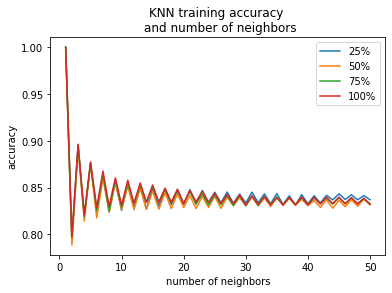

In [ ]:
print("adult knn train accuracy, weight = 'uniform'")

adult_train_25_result_u=knn_train(adult_25,50,'uniform','25%')
print('Best performance k for 25% of training data is',
      adult_train_25_result_u[0], 
      'accuracy is',adult_train_25_result_u[1])

adult_train_50_result_u=knn_train(adult_50,50,'uniform','50%')
print('Best performance k for 50% of training data is', 
      adult_train_50_result_u[0], 
      'accuracy is',adult_train_50_result_u[1])

adult_train_75_result_u=knn_train(adult_75,50,'uniform','75%')
print('Best performance k for 75% of training data is', 
      adult_train_75_result_u[0], 
      'accuracy is',adult_train_75_result_u[1])

adult_train_100_result_u=knn_train(adult_100,50,'uniform','100%')
print('Best performance k for 100% of training data is', 
      adult_train_100_result_u[0], 
      'accuracy is',adult_train_100_result_u[1])

adult_knn_u_train_result = [adult_train_25_result_u[1],adult_train_50_result_u[1],
                          adult_train_75_result_u[1],adult_train_100_result_u[1]]

adult knn k-fold, weight = 'uniform'
Best performance k for 25% of training data is 21 , accuracy is 0.8294429708222811
Best performance k for 50% of training data is 45 accuracy is 0.8259409324174506
Best performance k for 75% of training data is 33 accuracy is 0.8295465671766585
Best performance k for 100% of training data is 49 accuracy is 0.8298192976317227


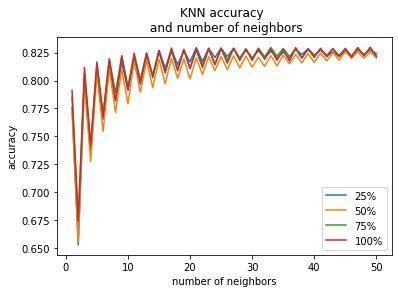

In [ ]:
print("adult knn k-fold, weight = 'uniform'")

adult_knn_k_fold_25_result_u=knn_k_fold(adult_25,50,'uniform','25%')
print('Best performance k for 25% of training data is', 
      adult_knn_k_fold_25_result_u[0], 
      ', accuracy is',adult_knn_k_fold_25_result_u[1])

adult_knn_k_fold_50_result_u=knn_k_fold(adult_50,50,'uniform','50%')
print('Best performance k for 50% of training data is', 
      adult_knn_k_fold_50_result_u[0], 
      'accuracy is',adult_knn_k_fold_50_result_u[1])

adult_knn_k_fold_75_result_u=knn_k_fold(adult_75,50,'uniform','75%')
print('Best performance k for 75% of training data is', 
      adult_knn_k_fold_75_result_u[0], 
      'accuracy is',adult_knn_k_fold_75_result_u[1])

adult_knn_k_fold_100_result_u=knn_k_fold(adult_100,50,'uniform','100%')
print('Best performance k for 100% of training data is', 
      adult_knn_k_fold_100_result_u[0], 
      'accuracy is',adult_knn_k_fold_100_result_u[1])

adult_knn_u_k_fold_result = [adult_knn_k_fold_25_result_u[1],adult_knn_k_fold_50_result_u[1],
                          adult_knn_k_fold_75_result_u[1],adult_knn_k_fold_100_result_u[1]]



In [ ]:
print("Apply previous results on testing sets.")
adult_knn_test_25_u = knn_test(adult_knn_k_fold_25_result_u[0],adult_25,'uniform')
print('Accuracy is',adult_knn_test_25_u, 
      ' for 25% of data trained for the model with best performance')
adult_knn_test_50_u = knn_test(adult_knn_k_fold_50_result_u[0],adult_50,'uniform')
print('Accuracy is',adult_knn_test_50_u, 
      ' for 50% of data trained for the model with best performance')
adult_knn_test_75_u = knn_test(adult_knn_k_fold_75_result_u[0],adult_75,'uniform')
print('Accuracy is',adult_knn_test_75_u, 
      ' for 75% of data trained for the model with best performance')
adult_knn_test_100_u = knn_test(adult_knn_k_fold_100_result_u[0],adult_100,'uniform')
print('Accuracy is',adult_knn_test_100_u, 
      ' for 100% of data trained for the model with best performance')

adult_knn_u_test_result = [adult_knn_test_25_u,adult_knn_test_50_u,
                          adult_knn_test_75_u,adult_knn_test_100_u]

Apply previous results on testing sets.
Accuracy is 0.8260292164674635  for 25% of data trained for the model with best performance
Accuracy is 0.8312084993359894  for 50% of data trained for the model with best performance
Accuracy is 0.8331341301460823  for 75% of data trained for the model with best performance
Accuracy is 0.8339973439575034  for 100% of data trained for the model with best performance


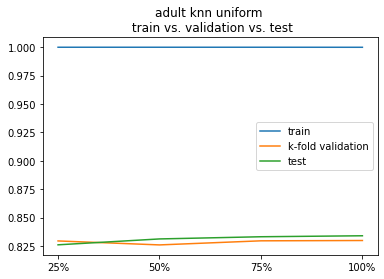

In [ ]:
plt.title("adult knn uniform \n train vs. validation vs. test")
#adult_knn_u_train_result
#adult_knn_u_k_fold_result
#adult_knn_u_test_result
x_axis = ['25%','50%','75%','100%']
plt.plot(x_axis, adult_knn_u_train_result, label = 'train')
plt.plot(x_axis, adult_knn_u_k_fold_result, label = 'k-fold validation')
plt.plot(x_axis, adult_knn_u_test_result, label = 'test')
plt.legend()

adult knn train accuracy, weight = 'distance'
Best performance k for 25% of training data is 50 accuracy is 1.0
Best performance k for 50% of training data is 50 accuracy is 1.0
Best performance k for 75% of training data is 50 accuracy is 1.0
Best performance k for 100% of training data is 1 accuracy is 0.9999668456998873


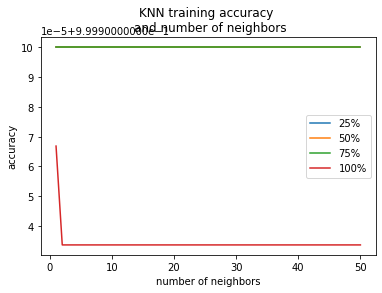

In [ ]:
print("adult knn train accuracy, weight = 'distance'")

adult_train_25_result_d=knn_train(adult_25,50,'distance','25%')
print('Best performance k for 25% of training data is', 
      adult_train_25_result_d[0], 
      'accuracy is',adult_train_25_result_d[1])

adult_train_50_result_d=knn_train(adult_50,50,'distance','50%')
print('Best performance k for 50% of training data is', 
      adult_train_50_result_d[0], 
      'accuracy is',adult_train_50_result_d[1])

adult_train_75_result_d=knn_train(adult_75,50,'distance','75%')
print('Best performance k for 75% of training data is', 
      adult_train_75_result_d[0], 
      'accuracy is',adult_train_75_result_d[1])

adult_train_100_result_d=knn_train(adult_100,50,'distance','100%')
print('Best performance k for 100% of training data is', 
      adult_train_100_result_d[0], 
      'accuracy is',adult_train_100_result_d[1])

adult_knn_d_train_result = [adult_train_25_result_d[1],adult_train_50_result_d[1],
                          adult_train_75_result_d[1],adult_train_100_result_d[1]]
#The graph may same werid since the difference in accuracy within k are so little so the y-axis are in a very small unit

adult knn k-fold, weight = 'distance'
Best performance k for 25% of training data is 26 , accuracy is 0.8075596816976127
Best performance k for 50% of training data is 36 accuracy is  0.8033293432705386
Best performance k for 75% of training data is 35 accuracy is  0.8145608846890331
Best performance k for 100% of training data is 17 accuracy is  0.8156293382591487


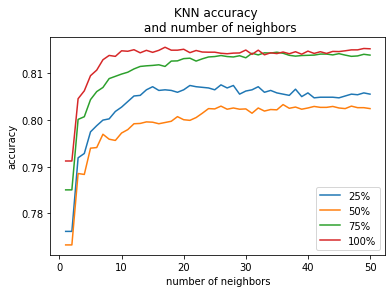

In [ ]:
print("adult knn k-fold, weight = 'distance'")

adult_knn_k_fold_25_result_d=knn_k_fold(adult_25,50,'distance','25%')
print('Best performance k for 25% of training data is', 
      adult_knn_k_fold_25_result_d[0], 
      ', accuracy is',adult_knn_k_fold_25_result_d[1])

adult_knn_k_fold_50_result_d=knn_k_fold(adult_50,50,'distance','50%')
print('Best performance k for 50% of training data is', 
      adult_knn_k_fold_50_result_d[0], 
      'accuracy is ',adult_knn_k_fold_50_result_d[1])

adult_knn_k_fold_75_result_d=knn_k_fold(adult_75,50,'distance','75%')
print('Best performance k for 75% of training data is', 
      adult_knn_k_fold_75_result_d[0], 
      'accuracy is ',adult_knn_k_fold_75_result_d[1])

adult_knn_k_fold_100_result_d=knn_k_fold(adult_100,50,'distance','100%')
print('Best performance k for 100% of training data is', 
      adult_knn_k_fold_100_result_d[0], 
      'accuracy is ',adult_knn_k_fold_100_result_d[1])

adult_knn_d_k_fold_result = [adult_knn_k_fold_25_result_d[1],adult_knn_k_fold_50_result_d[1],
                          adult_knn_k_fold_75_result_d[1],adult_knn_k_fold_100_result_d[1]]

In [ ]:
print("Apply previous results on testing sets.")
# knn_test(k, train_test_tuple,weight)
adult_knn_test_25_d = knn_test(adult_knn_k_fold_25_result_d[0],adult_25,'distance')
print('Accuracy is',adult_knn_test_25_d, 
      ' for 25% of data trained for the model with best performance')

adult_knn_test_50_d = knn_test(adult_knn_k_fold_50_result_d[0],adult_50,'distance')
print('Accuracy is',adult_knn_test_50_d, 
      ' for 50% of data trained for the model with best performance')

adult_knn_test_75_d = knn_test(adult_knn_k_fold_75_result_d[0],adult_75,'distance')
print('Accuracy is',adult_knn_test_75_d, 
      ' for 75% of data trained for the model with best performance')

adult_knn_test_100_d = knn_test(adult_knn_k_fold_100_result_d[0],adult_100,'distance')
print('Accuracy is',adult_knn_test_100_d, 
      ' for 100% of data trained for the model with best performance')

adult_knn_d_test_result = [adult_knn_test_25_d,adult_knn_test_50_d,
                          adult_knn_test_75_d,adult_knn_test_100_d]

Apply previous results on testing sets.
Accuracy is 0.8134130146082338  for 25% of data trained for the model with best performance
Accuracy is 0.8197211155378487  for 50% of data trained for the model with best performance
Accuracy is 0.8212483399734396  for 75% of data trained for the model with best performance
Accuracy is 0.8203851261620186  for 100% of data trained for the model with best performance


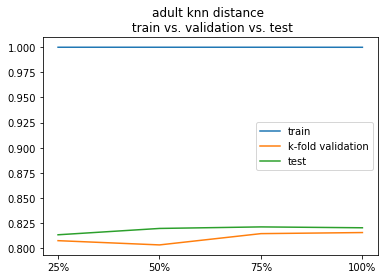

In [ ]:
plt.title("adult knn distance \n train vs. validation vs. test")
#adult_knn_d_train_result
#adult_knn_d_k_fold_result
#adult_knn_d_test_result
x_axis = ['25%','50%','75%','100%']
plt.plot(x_axis, adult_knn_d_train_result, label = 'train')
plt.plot(x_axis, adult_knn_d_k_fold_result, label = 'k-fold validation')
plt.plot(x_axis, adult_knn_d_test_result, label = 'test')
plt.legend()

adult decision tree train accuracy
Best performance k for 25% of training data is [12, 1] accuracy is 0.9
Best performance k for 50% of training data is [12, 1] accuracy is 0.883097937802533
Best performance k for 75% of training data is [12, 1] accuracy is 0.8774202104146406
Best performance k for 100% of training data is [12, 1] accuracy is 0.8776274782839334


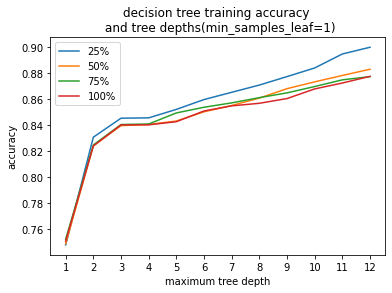

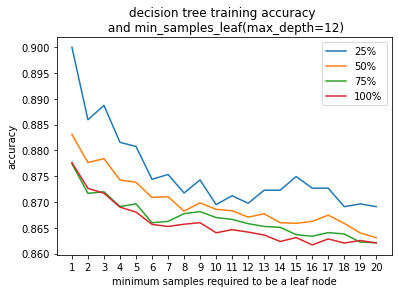

In [ ]:
print("adult decision tree train accuracy")

adult_train_dt_25_result=decision_tree_train(adult_25,'25%')
print('Best performance k for 25% of training data is', 
      adult_train_dt_25_result[0], 
      'accuracy is',adult_train_dt_25_result[1])

adult_train_dt_50_result=decision_tree_train(adult_50,'50%')
print('Best performance k for 50% of training data is', 
      adult_train_dt_50_result[0], 
      'accuracy is',adult_train_dt_50_result[1])

adult_train_dt_75_result=decision_tree_train(adult_75,'75%')
print('Best performance k for 75% of training data is', 
      adult_train_dt_75_result[0], 
      'accuracy is',adult_train_dt_75_result[1])

adult_train_dt_100_result=decision_tree_train(adult_100,'100%')
print('Best performance k for 100% of training data is', SS
      adult_train_dt_100_result[0], 
      'accuracy is',adult_train_dt_100_result[1])

adult_dt_train_result = [adult_train_dt_25_result[1],adult_train_dt_50_result[1],
                       adult_train_dt_75_result[1],adult_train_dt_100_result[1]]

decision tree k-fold, 25%
Best performance max-depth for 25% training data is 4 ,min-samples-leaf is 7 ,accuray is 0.8440318302387269
decision tree k-fold, 50%
Best performance max-depth for 50% training data is 7 ,min-samples-leaf is 6 ,accuray is 0.8443743191763033
decision tree k-fold, 75%
Best performance max-depth for 75% training data is 5 ,min-samples-leaf is 11 ,accuray is 0.8472286265854463
decision tree k-fold, 100%
Best performance max-depth for 100% training data is 6 ,min-samples-leaf is 13 ,accuray is 0.8459655453754982


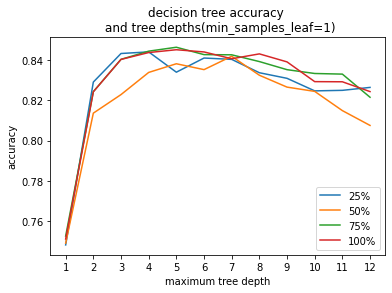

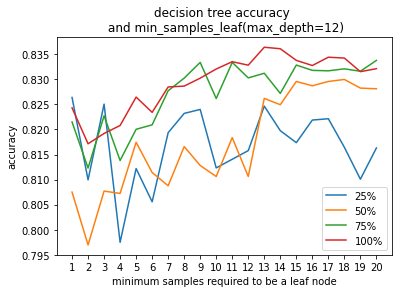

In [ ]:
print("decision tree k-fold, 25%")

adult_decision_tree_k_fold_25 = decision_tree_k_fold(adult_25,'25%')
print('Best performance max-depth for 25% training data is',
      adult_decision_tree_k_fold_25[0][0],
      ',min-samples-leaf is',adult_decision_tree_k_fold_25[0][1],
      ',accuray is',adult_decision_tree_k_fold_25[1])

print("decision tree k-fold, 50%")

adult_decision_tree_k_fold_50 = decision_tree_k_fold(adult_50,'50%')
print('Best performance max-depth for 50% training data is',
      adult_decision_tree_k_fold_50[0][0],
      ',min-samples-leaf is', adult_decision_tree_k_fold_50[0][1],
      ',accuray is',adult_decision_tree_k_fold_50[1])

print("decision tree k-fold, 75%")

adult_decision_tree_k_fold_75 = decision_tree_k_fold(adult_75,'75%')
print('Best performance max-depth for 75% training data is',
      adult_decision_tree_k_fold_75[0][0],
      ',min-samples-leaf is',adult_decision_tree_k_fold_75[0][1],
      ',accuray is',adult_decision_tree_k_fold_75[1])

print("decision tree k-fold, 100%")

adult_decision_tree_k_fold_100 = decision_tree_k_fold(adult_100,'100%')
print('Best performance max-depth for 100% training data is',
      adult_decision_tree_k_fold_100[0][0],
      ',min-samples-leaf is',adult_decision_tree_k_fold_100[0][1],
      ',accuray is',adult_decision_tree_k_fold_100[1])

adult_dt_k_fold_result = [adult_decision_tree_k_fold_25[1],adult_decision_tree_k_fold_50[1],
                       adult_decision_tree_k_fold_75[1],adult_decision_tree_k_fold_100[1]]

In [ ]:
print("Apply previous results on testing sets.")
adult_decision_tree_test_25 = decision_tree_test(adult_25,adult_decision_tree_k_fold_25[0][0],adult_decision_tree_k_fold_25[0][1])
print(adult_decision_tree_test_25)
adult_decision_tree_test_50= decision_tree_test(adult_50,adult_decision_tree_k_fold_50[0][0],adult_decision_tree_k_fold_50[0][1])
print(adult_decision_tree_test_50)
adult_decision_tree_test_75 = decision_tree_test(adult_75,adult_decision_tree_k_fold_75[0][0],adult_decision_tree_k_fold_75[0][1])
print(adult_decision_tree_test_75)
adult_decision_tree_test_100 = decision_tree_test(adult_100,adult_decision_tree_k_fold_100[0][0],adult_decision_tree_k_fold_100[0][1])
print(adult_decision_tree_test_100)

adult_dt_test_result = [adult_decision_tree_test_25,adult_decision_tree_test_50,
                       adult_decision_tree_test_75,adult_decision_tree_test_100]

Apply previous results on testing sets.
0.8396414342629482
0.849667994687915
0.84734395750332
0.850597609561753


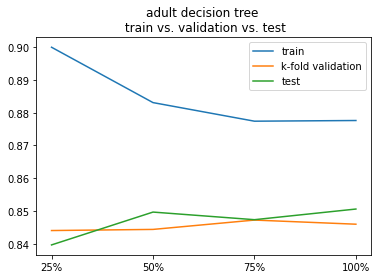

In [ ]:
plt.title("adult decision tree \n train vs. validation vs. test")

x_axis = ['25%','50%','75%','100%']
plt.plot(x_axis, adult_dt_train_result, label = 'train')
plt.plot(x_axis, adult_dt_k_fold_result, label = 'k-fold validation')
plt.plot(x_axis, adult_dt_test_result, label = 'test')
plt.legend()

# The second dataset

In [27]:
occ_0 = open('datatest.txt','r')
occ_1 = open('datatraining.txt','r')
occ_2 = open('datatest2.txt','r')
occ_2_header = occ_2.readline()

occ_train = open('occ_train.txt','w')
occ_test = open('occ_test.txt','w')

for i in range(0,2666):
    occ_train.write(occ_0.readline())
occ_1.readline()
for i in range(0,8145):
    occ_train.write(occ_1.readline())
occ_train.write('\n')
for i in range(0,3582):
    occ_train.write(occ_2.readline())

occ_test.write(occ_2_header)
for i in range(0,6172):
    occ_test.write(occ_2.readline())
occ_0.close()
occ_1.close()
occ_2.close()
occ_train.close()
occ_test.close()

In [28]:
occ_25=occupancy_clean('occ_train.txt',0.25)
occ_50=occupancy_clean('occ_train.txt',0.50)
occ_75=occupancy_clean('occ_train.txt',0.75)
occ_100=occupancy_clean('occ_train.txt',1.0)
occ_test=occupancy_clean('occ_test.txt',1.0)
occ_25=occupancy_preprocess(occ_25,'l2') + occupancy_preprocess(occ_test,'l2')
occ_50=occupancy_preprocess(occ_50,'l2') + occupancy_preprocess(occ_test,'l2')
occ_75=occupancy_preprocess(occ_75,'l2') + occupancy_preprocess(occ_test,'l2')
occ_100=occupancy_preprocess(occ_100,'l2') + occupancy_preprocess(occ_test,'l2')


occupancy train accuracy, weight = 'uniform'
Best performance k for 25% of training data is 1 accuracy is 1.0
Best performance k for 50% of training data is 1 accuracy is 1.0
Best performance k for 75% of training data is 1 accuracy is 1.0
Best performance k for 100% of training data is 1 accuracy is 1.0


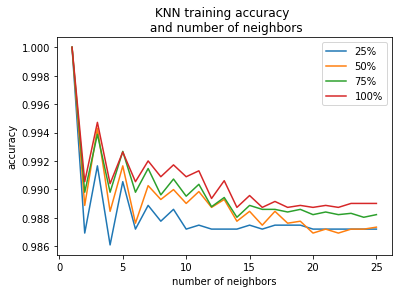

In [ ]:
print("occupancy train accuracy, weight = 'uniform'")

occ_train_25_result_u=knn_train(occ_25,25,'uniform','25%')
print('Best performance k for 25% of training data is', 
      occ_train_25_result_u[0], 
      'accuracy is',occ_train_25_result_u[1])

occ_train_50_result_u=knn_train(occ_50,25,'uniform','50%')
print('Best performance k for 50% of training data is', 
      occ_train_50_result_u[0], 
      'accuracy is',occ_train_50_result_u[1])

occ_train_75_result_u=knn_train(occ_75,25,'uniform','75%')
print('Best performance k for 75% of training data is', 
      occ_train_75_result_u[0], 
      'accuracy is',occ_train_75_result_u[1])

occ_train_100_result_u=knn_train(occ_100,25,'uniform','100%')
print('Best performance k for 100% of training data is', 
      occ_train_100_result_u[0], 
      'accuracy is',occ_train_100_result_u[1])

occ_knn_u_train_result = [occ_train_25_result_u[1],occ_train_50_result_u[1],
                          occ_train_75_result_u[1],occ_train_100_result_u[1]]

occupancy knn k-fold, num_neighbors from 1 to 25, weight = 'uniform'
Best performance k for 25% of training data is 13 , accuracy is 0.9841608266328657
Best performance k for 50% of training data is 3 accuracy is 0.9883252258512858
Best performance k for 75% of training data is 3 accuracy is 0.9868424981979199
Best performance k for 100% of training data is 3 accuracy is 0.9881862404447533


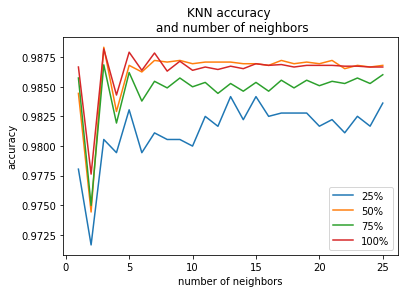

In [29]:
print("occupancy knn k-fold, num_neighbors from 1 to 25, weight = 'uniform'")

occ_knn_k_fold_25_result_u=knn_k_fold(occ_25,25,'uniform','25%')
print('Best performance k for 25% of training data is', 
      occ_knn_k_fold_25_result_u[0], 
      ', accuracy is',occ_knn_k_fold_25_result_u[1])

occ_knn_k_fold_50_result_u=knn_k_fold(occ_50,25,'uniform','50%')
print('Best performance k for 50% of training data is', 
      occ_knn_k_fold_50_result_u[0], 
      'accuracy is',occ_knn_k_fold_50_result_u[1])

occ_knn_k_fold_75_result_u=knn_k_fold(occ_75,25,'uniform','75%')
print('Best performance k for 75% of training data is', 
      occ_knn_k_fold_75_result_u[0], 
      'accuracy is',occ_knn_k_fold_75_result_u[1])

occ_knn_k_fold_100_result_u=knn_k_fold(occ_100,25,'uniform','100%')
print('Best performance k for 100% of training data is', 
      occ_knn_k_fold_100_result_u[0], 
      'accuracy is',occ_knn_k_fold_100_result_u[1])

occ_knn_u_k_fold_result = [occ_knn_k_fold_25_result_u[1],occ_knn_k_fold_50_result_u[1],
                          occ_knn_k_fold_75_result_u[1],occ_knn_k_fold_100_result_u[1]]


In [ ]:
print("Apply to testing set")

occ_knn_test_25_u = knn_test(occ_knn_k_fold_25_result_u[0],occ_25,'uniform')
print('Accuracy is',occ_knn_test_25_u, 
      ' for 25% of data trained for the model with best performance')

occ_knn_test_50_u = knn_test(occ_knn_k_fold_50_result_u[0],occ_50,'uniform')
print('Accuracy is',occ_knn_test_50_u, 
      ' for 50% of data trained for the model with best performance')

occ_knn_test_75_u = knn_test(occ_knn_k_fold_75_result_u[0],occ_75,'uniform')
print('Accuracy is',occ_knn_test_75_u, 
      ' for 75% of data trained for the model with best performance')

occ_knn_test_100_u = knn_test(occ_knn_k_fold_100_result_u[0],occ_100,'uniform')
print('Accuracy is',occ_knn_test_100_u, 
      ' for 100% of data trained for the model with best performance')
occ_knn_u_test_result = [occ_knn_test_25_u,occ_knn_test_50_u,
                          occ_knn_test_75_u,occ_knn_test_100_u]

Apply to testing set
Accuracy is 0.9949756888168557  for 25% of data trained for the model with best performance
Accuracy is 0.9638573743922204  for 50% of data trained for the model with best performance
Accuracy is 0.965964343598055  for 75% of data trained for the model with best performance
Accuracy is 0.9606158833063209  for 100% of data trained for the model with best performance


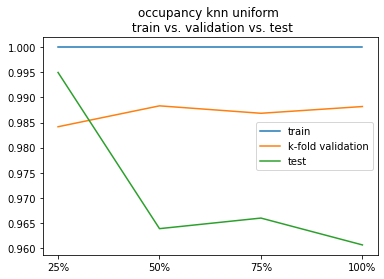

In [ ]:
plt.title("occupancy knn uniform \n train vs. validation vs. test")
#occ_knn_u_train_result
#occ_knn_u_k_fold_result
#occ_knn_u_test_result
x_axis = ['25%','50%','75%','100%']
plt.plot(x_axis, occ_knn_u_train_result, label = 'train')
plt.plot(x_axis, occ_knn_u_k_fold_result, label = 'k-fold validation')
plt.plot(x_axis, occ_knn_u_test_result, label = 'test')
plt.legend()

occupancy train accuracy, weight = 'distance'
Best performance k for 25% of training data is 25 accuracy is 1.0
Best performance k for 50% of training data is 25 accuracy is 1.0
Best performance k for 75% of training data is 25 accuracy is 1.0
Best performance k for 100% of training data is 25 accuracy is 1.0


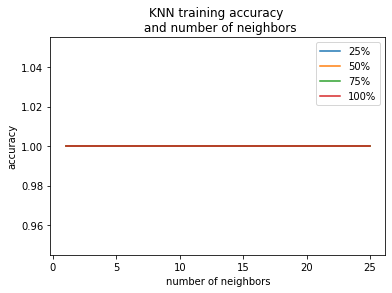

In [ ]:
print("occupancy train accuracy, weight = 'distance'")

occ_train_25_result_d=knn_train(occ_25,25,'distance','25%')
print('Best performance k for 25% of training data is', 
      occ_train_25_result_d[0], 
      'accuracy is',occ_train_25_result_d[1])

occ_train_50_result_d=knn_train(occ_50,25,'distance','50%')
print('Best performance k for 50% of training data is', 
      occ_train_50_result_d[0], 
      'accuracy is',occ_train_50_result_d[1])

occ_train_75_result_d=knn_train(occ_75,25,'distance','75%')
print('Best performance k for 75% of training data is', 
      occ_train_75_result_d[0], 
      'accuracy is',occ_train_75_result_d[1])

occ_train_100_result_d=knn_train(occ_100,25,'distance','100%')
print('Best performance k for 100% of training data is', 
      occ_train_100_result_d[0], 
      'accuracy is',occ_train_100_result_d[1])

occ_knn_d_train_result = [occ_train_25_result_d[1],occ_train_50_result_d[1],
                          occ_train_75_result_d[1],occ_train_100_result_d[1]]

occupancy knn k-fold, num_neighbors from 1 to 25 weight = 'distance'
Best performance k for 25% of training data is 24 , accuracy is 0.98304817016555
Best performance k for 50% of training data is  4 accuracy is 0.9886031966643503
Best performance k for 75% of training data is  5 accuracy is 0.9875837538186936
Best performance k for 100% of training data is  8 accuracy is 0.989784572619875


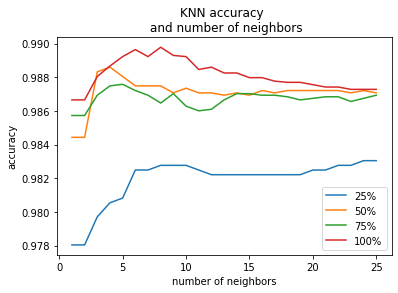

In [ ]:
print("occupancy knn k-fold, num_neighbors from 1 to 25 weight = 'distance'")

occ_knn_k_fold_25_result_d=knn_k_fold(occ_25,25,'distance','25%')
print('Best performance k for 25% of training data is', 
      occ_knn_k_fold_25_result_d[0], 
      ', accuracy is',occ_knn_k_fold_25_result_d[1])

occ_knn_k_fold_50_result_d=knn_k_fold(occ_50,25,'distance','50%')
print('Best performance k for 50% of training data is ', 
      occ_knn_k_fold_50_result_d[0], 
      'accuracy is',occ_knn_k_fold_50_result_d[1])

occ_knn_k_fold_75_result_d=knn_k_fold(occ_75,25,'distance','75%')
print('Best performance k for 75% of training data is ', 
      occ_knn_k_fold_75_result_d[0], 
      'accuracy is',occ_knn_k_fold_75_result_d[1])

occ_knn_k_fold_100_result_d=knn_k_fold(occ_100,25,'distance','100%')
print('Best performance k for 100% of training data is ', 
      occ_knn_k_fold_100_result_d[0], 
      'accuracy is',occ_knn_k_fold_100_result_d[1])

occ_knn_d_k_fold_result = [occ_knn_k_fold_25_result_d[1],occ_knn_k_fold_50_result_d[1],
                          occ_knn_k_fold_75_result_d[1],occ_knn_k_fold_100_result_d[1]]

In [ ]:
print("Apply to testing set")

occ_knn_test_25_d = knn_test(occ_knn_k_fold_25_result_d[0],occ_25,'distance')
print('Accuracy is',occ_knn_test_25_d, 
      ' for 25% of data trained for the model with best performance')

occ_knn_test_50_d = knn_test(occ_knn_k_fold_50_result_d[0],occ_50,'distance')
print('Accuracy is',occ_knn_test_50_d, 
      ' for 50% of data trained for the model with best performance')

occ_knn_test_75_d = knn_test(occ_knn_k_fold_75_result_d[0],occ_75,'distance')
print('Accuracy is',occ_knn_test_75_d, 
      ' for 75% of data trained for the model with best performance')

occ_knn_test_100_d = knn_test(occ_knn_k_fold_100_result_d[0],occ_100,'distance')
print('Accuracy is',occ_knn_test_100_d, 
      ' for 100% of data trained for the model with best performance')

occ_knn_d_test_result = [occ_knn_test_25_d,occ_knn_test_50_d,
                          occ_knn_test_75_d,occ_knn_test_100_d]

Apply to testing set
Accuracy is 0.9951377633711507  for 25% of data trained for the model with best performance
Accuracy is 0.9680713128038898  for 50% of data trained for the model with best performance
Accuracy is 0.965964343598055  for 75% of data trained for the model with best performance
Accuracy is 0.9609400324149109  for 100% of data trained for the model with best performance


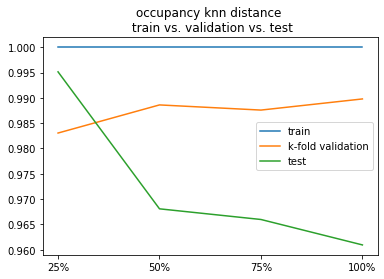

In [ ]:
plt.title("occupancy knn distance \n train vs. validation vs. test")
#occ_knn_d_train_result
#occ_knn_d_k_fold_result
#occ_knn_d_test_result
x_axis = ['25%','50%','75%','100%']
plt.plot(x_axis, occ_knn_d_train_result, label = 'train')
plt.plot(x_axis, occ_knn_d_k_fold_result, label = 'k-fold validation')
plt.plot(x_axis, occ_knn_d_test_result, label = 'test')
plt.legend()

occupancy decision tree train accuracy(model [max_depth, min_samples_leaf])
Best performance model for 25% of training data is [11, 1] accuracy is 0.9994441356309061
Best performance model for 50% of training data is [11, 1] accuracy is 0.9981931897150799
Best performance model for 75% of training data is [12, 1] accuracy is 0.998054114158636
Best performance model for 100% of training data is [12, 1] accuracy is 0.9984711605281446


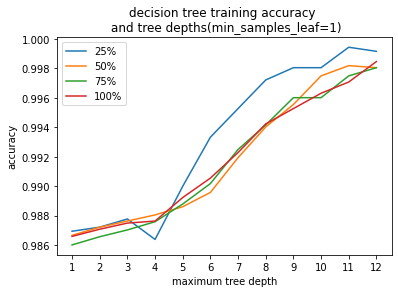

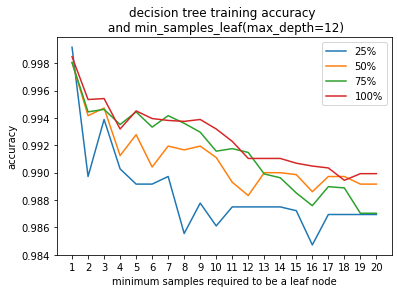

In [ ]:
print("occupancy decision tree train accuracy(model [max_depth, min_samples_leaf])")

occ_train_dt_25_result=decision_tree_train(occ_25,'25%')
print('Best performance model for 25% of training data is', 
      occ_train_dt_25_result[0], 
      'accuracy is',occ_train_dt_25_result[1])

occ_train_dt_50_result=decision_tree_train(occ_50,'50%')
print('Best performance model for 50% of training data is', 
      occ_train_dt_50_result[0], 
      'accuracy is',occ_train_dt_50_result[1])

occ_train_dt_75_result=decision_tree_train(occ_75,'75%')
print('Best performance model for 75% of training data is', 
      occ_train_dt_75_result[0], 
      'accuracy is',occ_train_dt_75_result[1])

occ_train_dt_100_result=decision_tree_train(occ_100,'100%')
print('Best performance model for 100% of training data is', 
      occ_train_dt_100_result[0], 
      'accuracy is',occ_train_dt_100_result[1])

occ_dt_train_result = [occ_train_dt_25_result[1],occ_train_dt_50_result[1],
                       occ_train_dt_75_result[1],occ_train_dt_100_result[1]]

occpancy decision tree k-fold
decision tree k-fold, 25%
Best performance max-depth for 25% training data is 12 ,min-samples-leaf is 20 ,accuray is 0.9866643036843261
decision tree k-fold, 50%
Best performance max-depth for 50% training data is 3 ,min-samples-leaf is 1 ,accuray is 0.9870743571924947
decision tree k-fold, 75%
Best performance max-depth for 75% training data is 2 ,min-samples-leaf is 3 ,accuray is 0.9860077060378265
decision tree k-fold, 100%
Best performance max-depth for 100% training data is 10 ,min-samples-leaf is 5 ,accuray is 0.9873523280055594


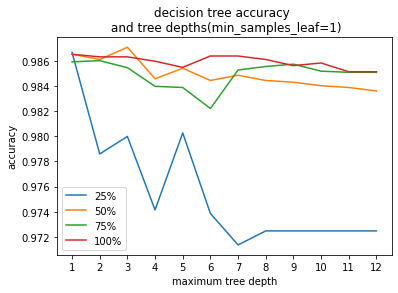

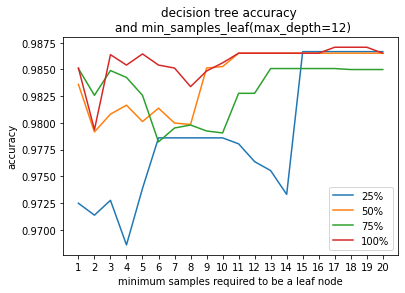

In [ ]:
print("occpancy decision tree k-fold")

print("decision tree k-fold, 25%")
occ_decision_tree_k_fold_25 = decision_tree_k_fold(occ_25,'25%')
print('Best performance max-depth for 25% training data is',
      occ_decision_tree_k_fold_25[0][0],
      ',min-samples-leaf is',occ_decision_tree_k_fold_25[0][1],
      ',accuray is',occ_decision_tree_k_fold_25[1])

print("decision tree k-fold, 50%")
occ_decision_tree_k_fold_50 = decision_tree_k_fold(occ_50,'50%')
print('Best performance max-depth for 50% training data is',
      occ_decision_tree_k_fold_50[0][0],
      ',min-samples-leaf is',occ_decision_tree_k_fold_50[0][1],
      ',accuray is',occ_decision_tree_k_fold_50[1])

print("decision tree k-fold, 75%")
occ_decision_tree_k_fold_75 = decision_tree_k_fold(occ_75,'75%')
print('Best performance max-depth for 75% training data is',
      occ_decision_tree_k_fold_75[0][0],
      ',min-samples-leaf is',occ_decision_tree_k_fold_75[0][1],
      ',accuray is',occ_decision_tree_k_fold_75[1])

print("decision tree k-fold, 100%")
occ_decision_tree_k_fold_100 = decision_tree_k_fold(occ_100,'100%')
print('Best performance max-depth for 100% training data is',
      occ_decision_tree_k_fold_100[0][0],
      ',min-samples-leaf is',occ_decision_tree_k_fold_100[0][1],
      ',accuray is',occ_decision_tree_k_fold_100[1])

occ_dt_k_fold_result = [occ_decision_tree_k_fold_25[1],occ_decision_tree_k_fold_50[1],
                       occ_decision_tree_k_fold_75[1],occ_decision_tree_k_fold_100[1]]

In [ ]:
print("Apply previous results on testing sets.")

occ_decision_tree_test_25 = decision_tree_test(occ_25,occ_decision_tree_k_fold_25[0][0],occ_decision_tree_k_fold_25[0][1])
print(occ_decision_tree_test_25)
occ_decision_tree_test_50 = decision_tree_test(occ_50,occ_decision_tree_k_fold_50[0][0],occ_decision_tree_k_fold_50[0][1])
print(occ_decision_tree_test_50)

occ_decision_tree_test_75 = decision_tree_test(occ_75,occ_decision_tree_k_fold_75[0][0],occ_decision_tree_k_fold_75[0][1])
print(occ_decision_tree_test_75)

#occ_decision_tree_test_75 = decision_tree_test(occ_75,9,1)
#print(occ_decision_tree_test_75)
occ_decision_tree_test_100 = decision_tree_test(occ_100,occ_decision_tree_k_fold_100[0][0],occ_decision_tree_k_fold_100[0][1])
print(occ_decision_tree_test_100)

occ_dt_test_result = [occ_decision_tree_test_25,occ_decision_tree_test_50,
                       occ_decision_tree_test_75,occ_decision_tree_test_100]

Apply previous results on testing sets.
0.9946515397082658
0.9800648298217179
0.9564019448946516
0.9638573743922204


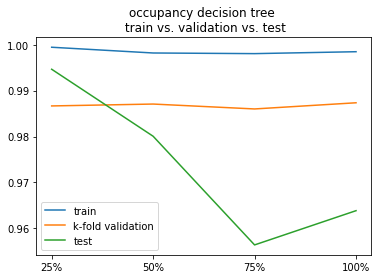

In [ ]:
plt.title("occupancy decision tree \n train vs. validation vs. test")

x_axis = ['25%','50%','75%','100%']
plt.plot(x_axis, occ_dt_train_result, label = 'train')
plt.plot(x_axis, occ_dt_k_fold_result, label = 'k-fold validation')
plt.plot(x_axis, occ_dt_test_result, label = 'test')
plt.legend()

# Different normalization techniques

adult_l1_knn_u_test 0.8339973439575034
adult_max_knn_u_test 0.8309428950863214
adult_l1_knn_d_test 0.8215139442231075
adult_max_knn_d_test 0.8245683930942895
adult_l1_dt_test 0.850597609561753
adult_max_dt_test 0.850597609561753


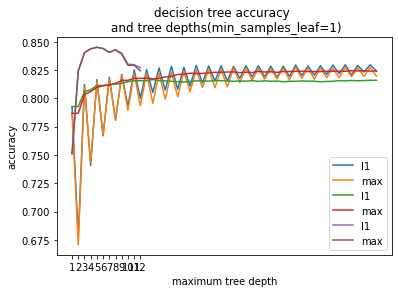

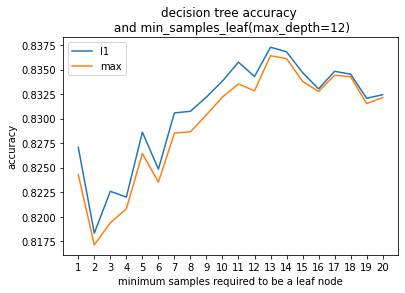

In [ ]:
adult_100_l1 = adult_preprocess(adult_clean_train("adult.data",1.0),adult_test,'l1')
adult_100_max = adult_preprocess(adult_clean_train("adult.data",1.0),adult_test,'max')


adult_l1_knn_u_k_fold = knn_k_fold(adult_100_l1,50,'uniform','l1')
adult_l1_knn_u_test = knn_test(adult_l1_knn_u_k_fold[0],adult_100_l1,'uniform')
print('adult_l1_knn_u_test',adult_l1_knn_u_test)


adult_max_knn_u_k_fold = knn_k_fold(adult_100_max,50,'uniform','max')
adult_max_knn_u_test = knn_test(adult_max_knn_u_k_fold[0],adult_100_max,'uniform')
print('adult_max_knn_u_test',adult_max_knn_u_test)

adult_l1_knn_d_k_fold = knn_k_fold(adult_100_l1,50,'distance','l1')
adult_l1_knn_d_test = knn_test(adult_l1_knn_d_k_fold[0],adult_100_l1,'distance')
print('adult_l1_knn_d_test',adult_l1_knn_d_test)

adult_max_knn_d_k_fold = knn_k_fold(adult_100_max,50,'distance','max')
adult_max_knn_d_test = knn_test(adult_max_knn_d_k_fold[0],adult_100_l1,'distance')
print('adult_max_knn_d_test',adult_max_knn_d_test)


adult_l1_dt_k_fold = decision_tree_k_fold(adult_100_l1,'l1')
adult_l1_dt_test = decision_tree_test(adult_100_l1, adult_l1_dt_k_fold[0][0], adult_l1_dt_k_fold[0][1])
print('adult_l1_dt_test',adult_l1_dt_test)


adult_max_dt_k_fold = decision_tree_k_fold(adult_100_max,'max')
adult_max_dt_test = decision_tree_test(adult_100_max, adult_max_dt_k_fold[0][0], adult_max_dt_k_fold[0][1])
print('adult_max_dt_test',adult_max_dt_test)

occ_l1_knn_u_test 0.9275526742301459
occ_max_knn_u_test 0.9230145867098866
occ_l1_knn_d_test 0.9275526742301459
occ_max_knn_d_test 0.9235008103727714
occ_l1_dt_test 0.9457050243111832
occ_max_dt_test 0.9497568881685575


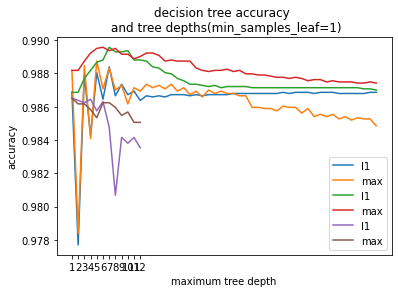

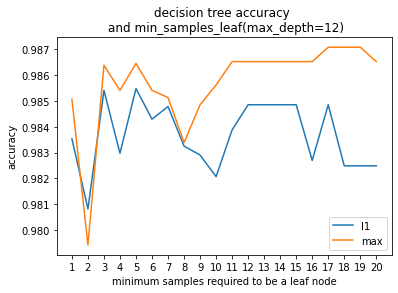

In [ ]:
occ_test_l1 = occupancy_preprocess(occupancy_clean("occ_test.txt",1.0),'l1')
occ_100_l1 = occupancy_preprocess(occupancy_clean("occ_train.txt",1.0),'l1')
occ_test_max = occupancy_preprocess(occupancy_clean("occ_test.txt",1.0),'max')
occ_100_max = occupancy_preprocess(occupancy_clean("occ_train.txt",1.0),'max')
occ_100_l1 = occ_100_l1 + occ_test_l1
occ_100_max = occ_100_max + occ_test_max


occ_l1_knn_u_k_fold = knn_k_fold(occ_100_l1,50,'uniform','l1')
occ_l1_knn_u_test = knn_test(occ_l1_knn_u_k_fold[0],occ_100_l1,'uniform')
print('occ_l1_knn_u_test',occ_l1_knn_u_test)

occ_max_knn_u_k_fold = knn_k_fold(occ_100_max,50,'uniform','max')
occ_max_knn_u_test = knn_test(occ_max_knn_u_k_fold[0],occ_100_max,'uniform')
print('occ_max_knn_u_test',occ_max_knn_u_test)

occ_l1_knn_d_k_fold = knn_k_fold(occ_100_l1,50,'distance','l1')
occ_l1_knn_d_test = knn_test(occ_l1_knn_d_k_fold[0],occ_100_l1,'distance')
print('occ_l1_knn_d_test',occ_l1_knn_d_test)

occ_max_knn_d_k_fold = knn_k_fold(occ_100_max,50,'distance','max')
occ_max_knn_d_test = knn_test(occ_max_knn_d_k_fold[0],occ_100_l1,'distance')
print('occ_max_knn_d_test',occ_max_knn_d_test)

occ_l1_dt_k_fold = decision_tree_k_fold(occ_100_l1,'l1')
occ_l1_dt_test = decision_tree_test(occ_100_l1, occ_l1_dt_k_fold[0][0], occ_l1_dt_k_fold[0][1])
print('occ_l1_dt_test',occ_l1_dt_test)

occ_max_dt_k_fold = decision_tree_k_fold(occ_100_max,'max')
occ_max_dt_test = decision_tree_test(occ_100_max, occ_max_dt_k_fold[0][0], occ_max_dt_k_fold[0][1])
print('occ_max_dt_test',occ_max_dt_test)

# Dropping Columns

In [11]:
def adult_clean_train_d1(file,length): #clean the data and return it as a numpy format length is the first num of rows we want to take
    df = pd.read_csv(file,header=None,skipinitialspace=True)
    df.columns = ["age", "workclass", "fnlwgt", "education", "education_num",
                                   "marital_status", "occupation", "relationship", "race", "sex",
                                   "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"]
    for attributes in df.columns:
        df = df[df[attributes] != '?']

    df = df.sample(frac=length,random_state=1)
    df = df.drop(columns="capital_gain",axis=1)
    df = df.drop(columns="capital_loss",axis=1)
    df = df.drop(columns="native_country",axis=1)
    
    return df

def adult_clean_test_d1(file):
    df = pd.read_csv(file, header=None, skiprows=1,skipinitialspace=True)
    df.columns = ["age", "workclass", "fnlwgt", "education", "education_num",
                  "marital_status", "occupation", "relationship", "race", "sex",
                  "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"]
    for attributes in df.columns:
        df = df[df[attributes] != '?']
    df["income"] = df["income"].str.replace(".", "",regex=False)
    df = df.drop(columns="capital_gain",axis=1)
    df = df.drop(columns="capital_loss",axis=1)
    df = df.drop(columns="native_country",axis=1)
    return df

def adult_preprocess_d1(cleaned_data,test_data):
    
    #fnlwgt = (fnlwgt-fnlwgt.mean())/(fnlwgt.std())
    
    frames = [cleaned_data,test_data]
    line_num = cleaned_data.shape[0]
    cleaned_data = pd.concat(frames,axis = 0)
    normalizer = Normalizer()

    enc1 = OneHotEncoder(handle_unknown='ignore', sparse=False)

    age = cleaned_data[['age']].to_numpy().T  # continous needs squeeze
    age = normalizer.fit_transform(age)  # normalization
    age = np.squeeze(age)


    workclass = enc1.fit_transform(cleaned_data[['workclass']].to_numpy()).T  # categorical

    fnlwgt = cleaned_data[['fnlwgt']].to_numpy().T  # continuous
    fnlwgt = normalizer.fit_transform(fnlwgt)  # normalization
    fnlwgt = np.squeeze(fnlwgt)

    education = enc1.fit_transform(cleaned_data[['education']].to_numpy()).T  # categorical

    education_num = cleaned_data[['education_num']].to_numpy().T  # continuous
    education_num = normalizer.fit_transform(education_num)
    education_num = np.squeeze(education_num)

    marital_status = enc1.fit_transform(cleaned_data[['marital_status']].to_numpy()).T  # categorical

    occupation = enc1.fit_transform(cleaned_data[['occupation']].to_numpy()).T  # categorical

    relationship = enc1.fit_transform(cleaned_data[['relationship']].to_numpy()).T  # categorical
    
    race = enc1.fit_transform(cleaned_data[['race']].to_numpy()).T #categorical
    
    sex = enc1.fit_transform(cleaned_data[['sex']].to_numpy()).T  # categorical

#    capital_gain = cleaned_data[['capital_gain']].to_numpy().T  # continuous
#    capital_gain = normalizer.fit_transform(capital_gain)  # normalization
#    capital_gain = np.squeeze(capital_gain)

#    capital_loss = cleaned_data[['capital_loss']].to_numpy().T  # continuous
#    capital_loss = normalizer.fit_transform(capital_loss)  # normalization
#    capital_loss = np.squeeze(capital_loss)

    hours_per_week = cleaned_data[['hours_per_week']].to_numpy().T  # continuous
    hours_per_week = normalizer.fit_transform(hours_per_week)  # normalization
    hours_per_week = np.squeeze(hours_per_week)

#    native_country = enc1.fit_transform(cleaned_data[['native_country']].to_numpy()).T  # categorical
    enc_feature =  np.vstack([age,workclass,fnlwgt,education,education_num,marital_status,occupation,
                                        relationship,race,sex,hours_per_week]).T
    #print(enc_feature.shape)
    enc_label = enc1.fit_transform(cleaned_data[['income']].to_numpy())
    enc1_feature = enc_feature[:line_num,:]
    #print(enc1_feature.shape)
    #print(line_num)
    test_feature = enc_feature[line_num:,:]
    #print(test_feature.shape)
    enc1_label = enc_label[:line_num,:]
    test_label = enc_label[line_num:,:]
    pre_processed_tuple = (enc1_feature,enc1_label,test_feature,test_label)
    return pre_processed_tuple

In [12]:
adult_100_s=adult_clean_train_d1("adult.data", 1.0)
adult_test_s=adult_clean_test_d1("adult.test")
adult_s_prep = adult_preprocess_d1(adult_100_s,adult_test_s)
adult_knn_d1 = knn_test(49,adult_s_prep,'uniform')
print("Weight = 'uniform', the accuracy after deleting capital gain, capital loss and native country in Adult dataset is ",adult_knn_d1)
adult_knn_d1 = knn_test(17,adult_s_prep,'distance')
print("Weight = 'distance', the accuracy after deleting capital gain, capital loss and native country in Adult dataset is ",adult_knn_d1)

Weight = 'uniform', the accuracy after deleting capital gain, capital loss and native country in Adult dataset is  0.8276228419654714
Weight = 'distance', the accuracy after deleting capital gain, capital loss and native country in Adult dataset is  0.8117529880478087


In [22]:
def adult_clean_train_d2(file,length): #clean the data and return it as a numpy format length is the first num of rows we want to take
    df = pd.read_csv(file,header=None,skipinitialspace=True)
    df.columns = ["age", "workclass", "fnlwgt", "education", "education_num",
                                   "marital_status", "occupation", "relationship", "race", "sex",
                                   "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"]
    for attributes in df.columns:
        df = df[df[attributes] != '?']

    df = df.sample(frac=length,random_state=1)
    df = df.drop(columns="sex",axis=1)
    df = df.drop(columns="education",axis=1)
    df = df.drop(columns="education_num",axis=1)
    df = df.drop(columns="workclass",axis=1)
    df = df.drop(columns="occupation",axis=1)
    df = df.drop(columns="race",axis=1)
    df = df.drop(columns="relationship",axis=1)
    
    return df

def adult_clean_test_d2(file):
    df = pd.read_csv(file, header=None, skiprows=1,skipinitialspace=True)
    df.columns = ["age", "workclass", "fnlwgt", "education", "education_num",
                  "marital_status", "occupation", "relationship", "race", "sex",
                  "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"]
    for attributes in df.columns:
        df = df[df[attributes] != '?']
    df["income"] = df["income"].str.replace(".", "",regex=False)
    df = df.drop(columns="sex",axis=1)
    df = df.drop(columns="education",axis=1)
    df = df.drop(columns="education_num",axis=1)
    df = df.drop(columns="workclass",axis=1)
    df = df.drop(columns="occupation",axis=1)
    df = df.drop(columns="race",axis=1)
    df = df.drop(columns="relationship",axis=1)
    return df

def adult_preprocess_d2(cleaned_data,test_data):
    
    #fnlwgt = (fnlwgt-fnlwgt.mean())/(fnlwgt.std())
    
    frames = [cleaned_data,test_data]
    line_num = cleaned_data.shape[0]
    cleaned_data = pd.concat(frames,axis = 0)
    normalizer = Normalizer()

    enc1 = OneHotEncoder(handle_unknown='ignore', sparse=False)

    age = cleaned_data[['age']].to_numpy().T  # continous needs squeeze
    age = normalizer.fit_transform(age)  # normalization
    age = np.squeeze(age)


    fnlwgt = cleaned_data[['fnlwgt']].to_numpy().T  # continuous
    fnlwgt = normalizer.fit_transform(fnlwgt)  # normalization
    fnlwgt = np.squeeze(fnlwgt)

    marital_status = enc1.fit_transform(cleaned_data[['marital_status']].to_numpy()).T  # categorical

    #relationship = enc1.fit_transform(cleaned_data[['relationship']].to_numpy()).T  # categorical
    
    capital_gain = cleaned_data[['capital_gain']].to_numpy().T  # continuous
    capital_gain = normalizer.fit_transform(capital_gain)  # normalization
    capital_gain = np.squeeze(capital_gain)

    capital_loss = cleaned_data[['capital_loss']].to_numpy().T  # continuous
    capital_loss = normalizer.fit_transform(capital_loss)  # normalization
    capital_loss = np.squeeze(capital_loss)

    hours_per_week = cleaned_data[['hours_per_week']].to_numpy().T  # continuous
    hours_per_week = normalizer.fit_transform(hours_per_week)  # normalization
    hours_per_week = np.squeeze(hours_per_week)

    native_country = enc1.fit_transform(cleaned_data[['native_country']].to_numpy()).T  # categorical
    enc_feature =  np.vstack([age,fnlwgt,marital_status,
                                    capital_gain,capital_loss,hours_per_week,native_country]).T
    #print(enc_feature.shape)
    enc_label = enc1.fit_transform(cleaned_data[['income']].to_numpy())
    enc1_feature = enc_feature[:line_num,:]
    #print(enc1_feature.shape)
    #print(line_num)
    test_feature = enc_feature[line_num:,:]
    #print(test_feature.shape)
    enc1_label = enc_label[:line_num,:]
    test_label = enc_label[line_num:,:]
    pre_processed_tuple = (enc1_feature,enc1_label,test_feature,test_label)
    return pre_processed_tuple

In [23]:
adult_100_d2 = adult_clean_train_d2("adult.data", 1.0)
adult_test_d2 = adult_clean_test_d2("adult.test")
adult_prep_d2 = adult_preprocess_d2(adult_100_d2,adult_test_d2)
adult_knn_d2 = knn_test(49,adult_prep_d2,'uniform')
print('Weight = "uniform", the accuracy after deleting sex, education, education_num, workclass, occupation, race, relationship in Adult dataset is  ',adult_knn_d2)
adult_knn_d2 = knn_test(17,adult_prep_d2,'distance')
print('Weight = "distance", the accuracy after deleting sex, education, education_num, workclass, occupation, race, relationship in Adult dataset is  ',adult_knn_d2)


Weight = "uniform", the accuracy after deleting sex, education, education_num, workclass, occupation, race, relationship in Adult dataset is   0.8118193891102258
Weight = "distance", the accuracy after deleting sex, education, education_num, workclass, occupation, race, relationship in Adult dataset is   0.8111553784860558


In [26]:
def occupancy_clean_d(file,length):
    df = pd.read_csv(file, header=None,skiprows=1, skipinitialspace=True)
    df.columns = ["num","date","Temperature","Humidity","Light","CO2","HumidityRatio","Occupancy"]
    df = df.drop(["num","date"], axis = 1)

    df = df.sample(frac=length)
    df = df.drop(columns="CO2",axis=1)
    return df

def occupancy_preprocess_d(cleaned_data):
    normalizer = Normalizer()
    enc1 = OneHotEncoder(handle_unknown='ignore', sparse=False)
    
    Temperature = cleaned_data[['Temperature']].to_numpy().T
    Temperature = normalizer.fit_transform(Temperature)
    Temperature = np.squeeze(Temperature)
    
    Humidity = cleaned_data[['Humidity']].to_numpy().T
    Humidity = normalizer.fit_transform(Humidity)
    Humidity = np.squeeze(Humidity)
    
    Light = cleaned_data[['Light']].to_numpy().T
    Light = normalizer.fit_transform(Light)
    Light = np.squeeze(Light)
    
#    CO2 = cleaned_data[['CO2']].to_numpy().T
#    CO2 = normalizer.fit_transform(CO2)
#    CO2 = np.squeeze(CO2)
    
    HumidityRatio = cleaned_data[['HumidityRatio']].to_numpy().T
    HumidityRatio = normalizer.fit_transform(HumidityRatio)
    HumidityRatio = np.squeeze(HumidityRatio)
    
    enc_feature = np.vstack([Temperature,Humidity,Light,HumidityRatio]).T
    enc_label = enc1.fit_transform(cleaned_data[['Occupancy']].to_numpy())
    pre_processed_tuple = (enc_feature, enc_label)
    return pre_processed_tuple

In [27]:
occ_100_d=occupancy_clean_d('occ_train.txt',1.0)
occ_test_d=occupancy_clean_d('occ_test.txt',1.0)
occ_prep_d=occupancy_preprocess_d(occ_100_d)+occupancy_preprocess_d(occ_test_d)
print('Weight = "uniform", the accuracy after deleting CO2 in Occupancy dataset is ', knn_test(3,occ_prep_d,'uniform'))
print('Weight = "distance", the accuracy after deleting CO2 in Occupancy dataset is ', knn_test(8,occ_prep_d,'distance'))

Weight = "uniform", the accuracy after deleting CO2 in Occupancy dataset is  0.9346839546191248
Weight = "distance", the accuracy after deleting CO2 in Occupancy dataset is  0.9517017828200972
